# Homework 2
> Выполнила Зыкова Вероника, БКЛ192

## Задание 1

**Способы**:
> Сразу замечу, что мне показалось более правильным привести способы, которые не совсем в точности копируют то, что приводилось на паре. Как минимум, их было бы интереснее реализовать. Поэтому методы не про грамматики, а скорее про то, что можно испольовать контрастные корпуса (извините, меня просто зацепила эта тема не так давно...).

1. Выделить все нграммы (2-3-граммы), которые не включают стоп слова и пунктуацию (кроме -, возможно, так как он используется внутри слов). Построить частотный словарь. Дальше можно взять наиболее частотные и вручную отобрать из них те, которые относятся к сущеостям данной категории. Это простой вариант. Необходим только изначальный корпус
> Плюсы:
> - быстро и просто
> 
> Минусы:
> - требует много ручной работы
> - много мусора в выдаче
2. Сделав всю ту же самоую предобработку, что и в первом пункте, можно поступить по-другому. Вообще, в первом случае мы получим в топе смесь сущностей и частотных, но ненужных на данном этапе коллокаций. Вторые можно попробовать убрать, если взять корпус с другой (лучше как можно более далекой) тематикой, и убрать из топа все коллокации, которые повторяются для двух корпусов. Оставшееся можно еще глазами проверить, но список в идеале должен получится чище. Нужен изначальный корпус и к нему в пару как можно более контрастный второй.
> Плюсы:
> - все еще быстро и просто
> - должно быть меньше мусора
> 
> Минусы:
> - все еще требует много ручной работы
3. Можно использовать классификацию и tf-idf достаточно странным способом: обучить интерпретируемый (статистический) классификатор типа логистической регрессии на tf-idf (для биграмм или триграмм) и посмотреть, каким словам модель дает наибольшие веса. Посомтреть, что это за слова. В иделае это будут сущности, и они же будут ключевыми словами во многом. Нужен изначальный корпус и к нему в пару как можно более контрастный второй.
> Плюсы:
> - более точная оценка важности слов
> 
> Минусы:
> - долго и сложно

*Вообще я в итоге попробовала все три, и ни один иделаьно не работает, зато с последним я заметила интересную закономерность, если постепенно выкидывать слова, веса которых меньше стандартного отклонения, умноженного на какое-то число (я просто зануляла веса в модели), то качество падает, но гораздо медленне, чем падает размерность. Теоретически, это логично, так как все, что меньше стандартного отклонения вообще особо не несет вклада, а чем дальше, тем больше вклад и быстрее падение точности. Но са факт того, что можно выкинуть что-то достаточно интересный. Хотя гипотеза о том, что нужные сущности окажутся где-то там как будто не совсем подтвердилась. И это работает только для бинарной линейеной классификации, так как там очень очевидно, как веса определеяют важность слова*

*Еще я в итоге работала с software, как с более понятной мне областью, однако второй и третий способы проверяла на других двух наборах, так как там больше объем корпуса. Но они в итоге не очень сработали, так что вернулась к первому*

### Imports and data reading

In [206]:
import json
import re
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from collections import Counter
from nltk.corpus import stopwords
from nltk import ngrams
from nltk import word_tokenize
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from nltk.stem import WordNetLemmatizer

In [207]:
def read_data(name):
    data = []
    with open(name, encoding='utf-8') as f:
        rd = f.read().splitlines()
        for el in tqdm(rd):
            text = json.loads(el).get('reviewText', '')
            if text != '':
                data.append(text)
    return data

In [208]:
sw_data = read_data('Arts_Crafts_and_Sewing_5.json')
cg_data = read_data('Video_Games_5.json')
sf_data = read_data('Software_5.json')

  0%|          | 0/494485 [00:00<?, ?it/s]

  0%|          | 0/497577 [00:00<?, ?it/s]

  0%|          | 0/12805 [00:00<?, ?it/s]

In [209]:
stops = stopwords.words('english')
with open('stops.json', encoding='utf-8') as f:
    fstops = json.load(f)
stops = set(stops) | set(fstops)

### Способ 1

In [210]:
def preprocess(sent, pattern=re.compile(r"[a-z0-9\-]+")):
    res = []
    global cache
    sent = word_tokenize(sent)
    for word in sent:
        new_word = word.lower()
        if new_word not in stops and pattern.fullmatch(new_word):
            if new_word not in cache:
                cache[new_word] = lemmatizer.lemmatize(new_word)
            res.append(cache[new_word])
    return ' '.join(res)

In [224]:
def get_ngrams(data, n=2, pattern=re.compile(r"[a-z0-9\-]+")):
    ngrs = Counter()
    for el in tqdm(data):
        sent = preprocess(el)
        ngrs.update(ngrams(sent.split(), n))
    return ngrs

In [227]:
sf_ngrs = get_ngrams(sf_data, n=1)
sf_ngrs.most_common(100)

  0%|          | 0/12804 [00:00<?, ?it/s]

[(('software',), 11475),
 (('program',), 10249),
 (('window',), 8461),
 (('version',), 8265),
 (('product',), 7636),
 (('year',), 6493),
 (('time',), 6376),
 (('work',), 6289),
 (('computer',), 6167),
 (('feature',), 5144),
 (('file',), 4928),
 (('-',), 4911),
 (('user',), 4637),
 (('--',), 4520),
 (('good',), 4482),
 (('video',), 4060),
 (('easy',), 3983),
 (('problem',), 3842),
 (('office',), 3711),
 (('great',), 3527),
 (('thing',), 3374),
 (('norton',), 3303),
 (('tax',), 3131),
 (('microsoft',), 3092),
 (('install',), 3063),
 (('update',), 3054),
 (('lot',), 2835),
 (('7',), 2809),
 (('mac',), 2792),
 (('upgrade',), 2777),
 (('photo',), 2410),
 (('security',), 2352),
 (('pro',), 2318),
 (('free',), 2274),
 (('price',), 2265),
 (('support',), 2213),
 (('installed',), 2201),
 (('review',), 2181),
 (('tool',), 2172),
 (('option',), 2135),
 (('issue',), 2100),
 (('quicken',), 2079),
 (('installation',), 2009),
 (('vista',), 1981),
 (('editing',), 1957),
 (('drive',), 1950),
 (('interf

In [238]:
sf_ngrs = get_ngrams(sf_data, n=2)
sf_ngrs.most_common(100)

  0%|          | 0/12804 [00:00<?, ?it/s]

[(('--', '--'), 2361),
 (('window', '7'), 2002),
 (('window', '8'), 1026),
 (('hard', 'drive'), 769),
 (('internet', 'security'), 746),
 (('window', 'xp'), 598),
 (('turbo', 'tax'), 596),
 (('product-link-linked', 'a-link-normal'), 581),
 (('previous', 'version'), 523),
 (('microsoft', 'office'), 522),
 (('video', 'editing'), 516),
 (('nbsp', 'product-link-linked'), 504),
 (('learning', 'curve'), 462),
 (('trend', 'micro'), 454),
 (('year', 'ago'), 451),
 (('user', 'interface'), 433),
 (('easy', 'install'), 351),
 (('norton', '360'), 350),
 (('long', 'time'), 349),
 (('window', '10'), 344),
 (('rosetta', 'stone'), 344),
 (('highly', 'recommend'), 331),
 (('photo', 'editing'), 331),
 (('paintshop', 'pro'), 328),
 (('small', 'business'), 310),
 (('work', 'great'), 304),
 (('running', 'window'), 303),
 (('older', 'version'), 291),
 (('editing', 'software'), 276),
 (('web', 'site'), 275),
 (('window', 'vista'), 274),
 (('office', '2007'), 265),
 (('great', 'product'), 262),
 (('security', 

### Способ 2

In [256]:
sw_ngrs = get_ngrams(sw_data[:10 ** 5])
cg_ngrs = get_ngrams(cg_data[:10 ** 5])

sw_set = set([el[0] for el in sw_ngrs.most_common(200)])
cg_set = set([el[0] for el in cg_ngrs.most_common(200)])

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Посмотрим сначала на одном из дополнительных, но тут как-то не очень

In [261]:
cg_all = {el: cg_ngrs[el] for el in cg_set - sw_set}

In [262]:
sorted(cg_all.items(), key=lambda x: x[1], reverse=True)

[(('game', 'play'), 10440),
 (('great', 'game'), 8986),
 (('game', 'game'), 8938),
 (('play', 'game'), 7753),
 (('final', 'fantasy'), 7022),
 (('video', 'game'), 6956),
 (('game', 'fun'), 5981),
 (('good', 'game'), 5950),
 (('game', 'great'), 5908),
 (('game', 'played'), 5613),
 (('game', 'good'), 5348),
 (('playing', 'game'), 5284),
 (('fun', 'game'), 5271),
 (('--', '--'), 4668),
 (('love', 'game'), 3902),
 (('game', 'time'), 3831),
 (('buy', 'game'), 3579),
 (('super', 'mario'), 3561),
 (('played', 'game'), 3476),
 (('single', 'player'), 3383),
 (('resident', 'evil'), 3342),
 (('thing', 'game'), 3306),
 (('voice', 'acting'), 3137),
 (('star', 'war'), 3092),
 (('game', 'graphic'), 3027),
 (('lot', 'fun'), 2901),
 (('fun', 'play'), 2858),
 (('game', 'lot'), 2820),
 (('time', 'game'), 2796),
 (('xbox', '360'), 2789),
 (('game', 'worth'), 2427),
 (('fighting', 'game'), 2269),
 (('game', 'pretty'), 2242),
 (('game', 'boy'), 2241),
 (('metal', 'gear'), 2152),
 (('mega', 'man'), 2127),
 ((

Теперь на основном

In [257]:
sf_set = set([el[0] for el in sf_ngrs.most_common(200)])

In [258]:
sf_all = {el: sf_ngrs[el] for el in sf_set - sw_set}
sf_other = {el: sf_ngrs[el] for el in sf_set & sw_set}

In [259]:
sorted(sf_all.items(), key=lambda x: x[1], reverse=True)

[(('--', '--'), 2361),
 (('window', '7'), 2002),
 (('window', '8'), 1026),
 (('hard', 'drive'), 769),
 (('internet', 'security'), 746),
 (('window', 'xp'), 598),
 (('turbo', 'tax'), 596),
 (('previous', 'version'), 523),
 (('microsoft', 'office'), 522),
 (('video', 'editing'), 516),
 (('learning', 'curve'), 462),
 (('trend', 'micro'), 454),
 (('user', 'interface'), 433),
 (('easy', 'install'), 351),
 (('norton', '360'), 350),
 (('window', '10'), 344),
 (('rosetta', 'stone'), 344),
 (('photo', 'editing'), 331),
 (('paintshop', 'pro'), 328),
 (('small', 'business'), 310),
 (('running', 'window'), 303),
 (('older', 'version'), 291),
 (('editing', 'software'), 276),
 (('web', 'site'), 275),
 (('window', 'vista'), 274),
 (('office', '2007'), 265),
 (('security', 'software'), 260),
 (('program', 'work'), 258),
 (('user', 'friendly'), 253),
 (('version', 'window'), 247),
 (('tech', 'support'), 246),
 (('tax', 'software'), 244),
 (('nancy', 'drew'), 243),
 (('64', 'bit'), 242),
 (('credit', 'c

In [260]:
sorted(sf_other.items(), key=lambda x: x[1], reverse=True)

[(('product-link-linked', 'a-link-normal'), 581),
 (('nbsp', 'product-link-linked'), 504),
 (('year', 'ago'), 451),
 (('long', 'time'), 349),
 (('highly', 'recommend'), 331),
 (('work', 'great'), 304),
 (('great', 'product'), 262),
 (('work', 'fine'), 227),
 (('good', 'product'), 225),
 (('pretty', 'good'), 217),
 (('5', 'star'), 214),
 (('highly', 'recommended'), 209),
 (('4', 'star'), 157),
 (('product', 'work'), 151),
 (('recommend', 'product'), 150),
 (('good', 'thing'), 133),
 (('great', 'deal'), 119),
 (('worth', 'price'), 117),
 (('great', 'price'), 104),
 (('read', 'review'), 99)]

### Способ 3

Всякая предобработка корпуса

In [269]:
corpus = pd.DataFrame()
corpus['text'] = sw_data + cg_data
corpus['class'] = [0 for _ in sw_data] + [1 for _ in cg_data]

In [270]:
corpus.head()

,text,class
0,Contains some interesting stitches.,1
1,I'm a fairly experienced knitter of the one-co...,1
2,Great book but the index is terrible. Had to w...,1
3,I purchased the Kindle edition which is incred...,1
4,Very well laid out and very easy to read.\n\nT...,1


In [271]:
lemmatizer = WordNetLemmatizer()
cache = {}

In [105]:
tqdm.pandas()
corpus['clean_text'] = corpus.text.progress_apply(preprocess)

  0%|          | 0/991615 [00:00<?, ?it/s]

In [272]:
# corpus.to_csv('corpus.csv', index=False)
corpus = pd.read_csv('corpus.csv')
corpus['class'] = 1 - corpus['class']

In [273]:
corpus.head()

,text,class,clean_text
0,Contains some interesting stitches.,1,interesting stitch
1,I'm a fairly experienced knitter of the one-co...,1,fairly experienced knitter one-color color blo...
2,Great book but the index is terrible. Had to w...,1,great book terrible write high light cross info
3,I purchased the Kindle edition which is incred...,1,purchased kindle edition incredibly handy trav...
4,Very well laid out and very easy to read.\n\nT...,1,laid easy read book nice size big larger prese...


In [274]:
corpus = corpus.dropna()

Обучим tf-idf и будем дальше с ним работать

In [279]:
tfidf = TfidfVectorizer()
vec = tfidf.fit_transform(corpus['clean_text'])
vocab = tfidf.get_feature_names_out()

Вектор долей в корпусе, так как потом возникла идея использовать это вместе с весами

In [284]:
def count_freq(texts, vocab):
    cc = Counter()
    for el in tqdm(texts):
        cc.update(el.split())
    res = []
    for el in vocab:
        res.append(cc[el])
    res = np.array(res)
    res = res / sum(res)
    return res

In [285]:
freq = count_freq(corpus[corpus['class'] == 1].clean_text, vocab)

  0%|          | 0/483405 [00:00<?, ?it/s]

In [287]:
vec.shape, vocab.shape, freq.shape

((972965, 189183), (189183,), (189183,))

Регрессия

In [288]:
lr = LogisticRegression(verbose=1, n_jobs=-1, max_iter=1000)

In [289]:
lr.fit(vec, corpus['class'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       189184     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.74408D+05    |proj g|=  3.00858D+04


 This problem is unconstrained.



At iterate   50    f=  1.62145D+05    |proj g|=  3.93545D+02

At iterate  100    f=  1.54227D+05    |proj g|=  3.70760D+02

At iterate  150    f=  1.53135D+05    |proj g|=  6.40873D+01

At iterate  200    f=  1.52961D+05    |proj g|=  3.16939D+01

At iterate  250    f=  1.52918D+05    |proj g|=  2.23345D+01

At iterate  300    f=  1.52914D+05    |proj g|=  2.32175D+00

At iterate  350    f=  1.52913D+05    |proj g|=  1.66039D+00

At iterate  400    f=  1.52913D+05    |proj g|=  1.74870D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****    402    460      1     0     0   1.184D+00   1.529D+05
  F =   152912.760037

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   39.2s finished


LogisticRegression(max_iter=1000, n_jobs=-1, verbose=1)

In [290]:
lr.score(vec, corpus['class'])

0.9335875391201123

Сохраним веса отдельно, и будем их тихонько двигать. Везде копии, чтобы ничего не переопределилось (ох уж эти ссылки...)

Вообще, было удивительно узнать, что у обученной модели можно взять и переопределить веса... Просто так, даже не через метод

In [293]:
coefs = {}
coefs['0'] = np.copy(lr.coef_[0])
cf = np.copy(lr.coef_[0])
std = np.std(cf)

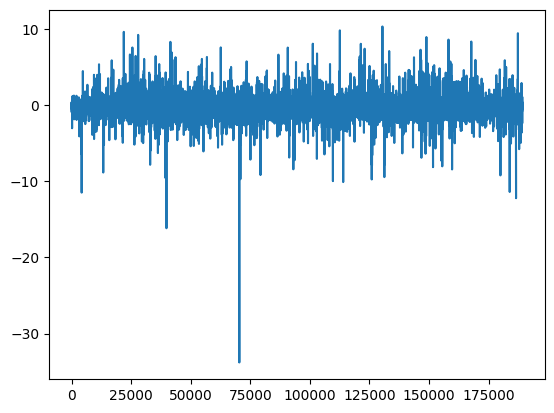

In [301]:
plt.plot(cf)

Постепенно сдвигаем границу значащих признаков от нуля до максимального по модулю и смотрим точность. Получается интересно.

In [313]:
def check_lines(cf, lr):
    res = []
    lines = np.arange(0, np.max(np.abs(cf)), 0.05)
    for line in tqdm(lines):
        tmp = np.copy(cf)
        tmp[np.abs(tmp) <= line] = 0
        lr.coef_[0] = tmp
        n = tmp[tmp != 0].shape[0]
        sc = lr.score(vec, corpus['class'])
        res.append([line, n, sc])
    return np.array(res)

In [314]:
res_lines = check_lines(cf, lr)

  0%|          | 0/676 [00:00<?, ?it/s]

Графки интересный чисто с познавательной точки зрения, однако в задаче это ничем не помогло, так как в списке слов скорее тематико-специфические слова, а не сущности (стоило бы догадаться, там же именно они и треггерят выбор класса)

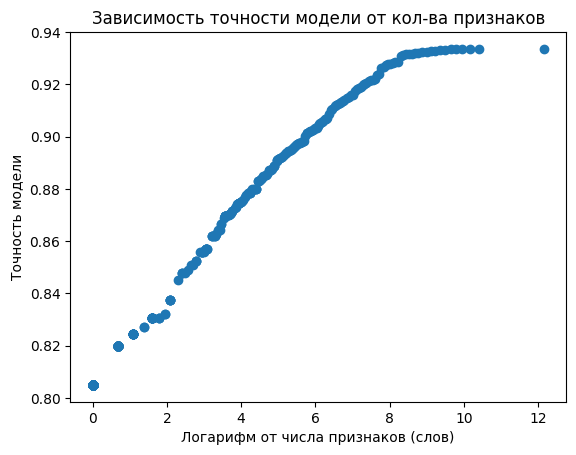

In [325]:
plt.scatter(np.log(res_lines[:, 1]), res_lines[:, 2])
plt.xlabel('Логарифм от числа признаков (слов)')
plt.ylabel('Точность модели')
plt.title('Зависимость точности модели от кол-ва признаков')
plt.show()

In [337]:
res_lines[80]

array([  4.        , 232.        ,   0.89630254])

In [336]:
words[np.where(np.abs(cf) >= 4)]

array(['2ds', '360', '3d', '45', 'action', 'airbrush', 'album', 'amiibo',
       'amiibos', 'analog', 'arcade', 'artist', 'assortment', 'audio',
       'battery', 'battle', 'bead', 'beading', 'beginner', 'blade',
       'blanket', 'bobbin', 'boring', 'boyfriend', 'bracelet', 'brush',
       'cable', 'camera', 'candle', 'canvas', 'chain', 'chalk',
       'character', 'charge', 'charger', 'charging', 'classic', 'clay',
       'cod', 'code', 'collector', 'color', 'coloring', 'console',
       'container', 'control', 'controller', 'copy', 'craft', 'crafter',
       'crafting', 'cricut', 'crochet', 'crocheting', 'cut', 'cutter',
       'cutting', 'dance', 'die', 'disc', 'dlc', 'download', 'driver',
       'drum', 'dry', 'dsi', 'dy', 'dye', 'earring', 'edition',
       'embossing', 'embroidery', 'entertaining', 'eraser', 'exercise',
       'expansion', 'fabric', 'fan', 'flower', 'folder', 'fps',
       'franchise', 'game', 'gameboy', 'gamecube', 'gamepad', 'gameplay',
       'gamer', 'gamers

### Способ 3.1

In [340]:
fcf = cf * freq

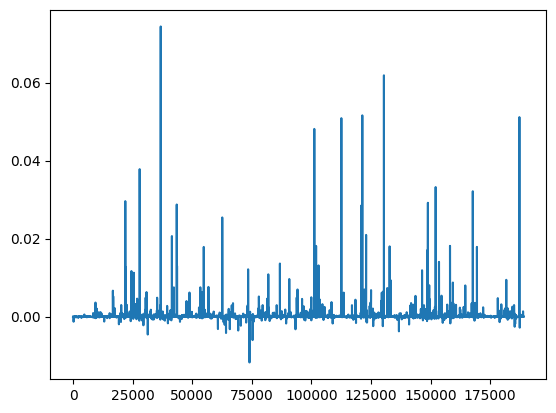

In [345]:
plt.plot(fcf)

In [350]:
vocab[fcf.argsort()[-100:]]

array(['coloring', 'earring', 'vinyl', 'bottle', 'easily', 'medium',
       'book', 'store', 'thick', 'ordered', 'easier', 'foot', 'ring',
       'tiny', 'stencil', 'piece', 'acrylic', 'smooth', 'embossing',
       'mold', 'large', 'crafting', 'design', 'pretty', 'order', 'mat',
       'sheet', 'sew', 'larger', 'bracelet', 'hold', 'variety', 'clay',
       'canvas', 'kit', 'love', 'needed', 'handle', 'cricut', 'artist',
       'ruler', 'soft', 'water', 'smaller', 'cutter', 'nice', 'price',
       'die', 'card', 'dy', 'quilting', 'product', 'art', 'pin',
       'knitting', 'pattern', 'punch', 'crochet', 'dry', 'embroidery',
       'tape', 'sharp', 'painting', 'stitch', 'quilt', 'watercolor',
       'jewelry', 'hook', 'bobbin', 'pen', 'blade', 'scissors', 'glue',
       'beautiful', 'cutting', 'marker', 'ink', 'small', 'set', 'easy',
       'tool', 'quality', 'making', 'stamp', 'craft', 'pencil', 'fabric',
       'paint', 'cut', 'sewing', 'bead', 'thread', 'size', 'brush',
       'machin

Тут тоже ничего особо полезного не вышло. А идея была вот в чем: если слово частотное и при этом имеет большой вклад в текущий класс, то мы хотим его найти. Но нашлось опять что-то странное

## Задание 2

### Способ 1 еще раз, чтобы было удобнее работать

In [362]:
sf_ngrs = get_ngrams(sf_data, n=1)
res = [' '.join(el[0]) for el in sf_ngrs.most_common(100)]
sf_ngrs = get_ngrams(sf_data, n=2)
res.extend([' '.join(el[0]) for el in sf_ngrs.most_common(100)])

  0%|          | 0/12804 [00:00<?, ?it/s]

  0%|          | 0/12804 [00:00<?, ?it/s]

In [363]:
print(res)

['software', 'program', 'window', 'version', 'product', 'year', 'time', 'work', 'computer', 'feature', 'file', '-', 'user', '--', 'good', 'video', 'easy', 'problem', 'office', 'great', 'thing', 'norton', 'tax', 'microsoft', 'install', 'update', 'lot', '7', 'mac', 'upgrade', 'photo', 'security', 'pro', 'free', 'price', 'support', 'installed', 'review', 'tool', 'option', 'issue', 'quicken', 'installation', 'vista', 'editing', 'drive', 'interface', 'xp', 'corel', 'internet', 'word', 'running', 'data', 'bit', '2', 'game', 'people', '8', 'start', 'day', 'download', 'business', 'buy', 'screen', 'device', '3', 'pretty', 'online', 'set', 'application', 'hard', 'recommend', 'suite', 'simple', 'document', 'machine', 'laptop', 'turbotax', 'basic', '10', 'long', 'package', 'account', 'nice', 'form', '1', 'virus', 'money', '5', 'open', 'protection', 'return', 'learning', 'image', 'process', 'number', 'create', 'backup', 'experience', 'worked', '-- --', 'window 7', 'window 8', 'hard drive', 'interne

In [378]:
# with open('entiies.txt', 'w', encoding='utf-8') as f:
#     f.write('\n'.join(res))

## Задание 3

In [384]:
with open('entiies.txt', 'r', encoding='utf-8') as f:
    ents = f.read()

In [386]:
ents = ents.splitlines()

Давайте возьмем только двусловные, они как будто более содержательные

In [389]:
ents = [el for el in ents if ' ' in el]
ents

['hard drive',
 'internet security',
 'microsoft office',
 'video editing',
 'learning curve',
 'user interface',
 'norton 360',
 'window 10',
 'rosetta stone',
 'photo editing',
 'paintshop pro',
 'running window',
 'editing software',
 'web site',
 'window vista',
 'office 2007',
 'security software',
 'tech support',
 'customer service',
 'security suite',
 'norton internet',
 'norton product',
 'start menu',
 'mac version',
 'window version',
 'adobe photoshop',
 'virus protection',
 'customer support',
 'corel videostudio',
 'software program',
 'norton antivirus']

In [450]:
def get_ngrams(data):
    sf_data_new = []
    for sent in tqdm(data):
        cur = ngrams(preprocess(sent).split(), 3)
        for ent in ents:
            for ngr in cur:
                ngr = ' '.join(ngr)
                if ent in ngr:
                    sf_data_new.append(ngr.replace(ent, ent.replace(' ', '_')))
    return sf_data_new

In [453]:
bigrs = get_ngrams(sf_data)

  0%|          | 0/12804 [00:00<?, ?it/s]

In [454]:
len(bigrs)

1530

In [455]:
bigrs[:10]

['folder hard_drive',
 'hard_drive open',
 'dvd hard_drive',
 'hard_drive play',
 'local hard_drive',
 'hard_drive synchronizing',
 'local hard_drive',
 'hard_drive 3',
 'awhile hard_drive',
 'hard_drive dvd']

## Задание 4

### Способ 1
Среднее +- квадратичное отклонение от средней позиции

In [456]:
def prep_bigrs(bis):
    new_bis = {}
    for bi in bis:
        pos = bi.index('_')
        bi = bi.split()
        if pos >= len(bi[0]):
            bi.reverse()
        if bi[0] not in new_bis:
            new_bis[bi[0]] = {}
        if bi[1] not in new_bis[bi[0]]:
            new_bis[bi[0]][bi[1]] = 0
        new_bis[bi[0]][bi[1]] += 1
    return new_bis

In [457]:
bis = prep_bigrs(bigrs)

In [459]:
def get_positions(data, bis):
    res = {}
    for sent in tqdm(data):
        new_sent = sent.split()
        for ent_ref in bis:
            if ent_ref not in res:
                res[ent_ref] = {}
            if ent_ref in new_sent:
                eidx = new_sent.index(ent_ref)
                for ent_cur in bis[ent_ref]:
                    if ent_cur != ent_ref:
                        if ent_cur not in res[ent_ref]:
                            res[ent_ref][ent_cur] = []
                        if ent_cur in new_sent:
                            cidx = new_sent.index(ent_cur)
                            pos = eidx - cidx
                            if abs(pos) <= 2:
                                res[ent_ref][ent_cur].append(pos)
    return res

In [460]:
freq_pos = get_positions(sf_data_new, bis)

  0%|          | 0/1530 [00:00<?, ?it/s]

In [461]:
freq_pos

{'hard_drive': {'folder': [1],
  'open': [-1, -1, -1],
  'dvd': [1, -1, 1, -1, 1, -1, -1, -1, -1, 1, -1],
  'play': [-1, -1, -1],
  'local': [1, 1, 1, 1, 1, 1, 1, 1],
  'synchronizing': [-1, -1],
  '3': [-1, 1, -1],
  'awhile': [1],
  'crashed': [1, -1, -1],
  'employee': [-1],
  'size': [1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, -1],
  'space': [-1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   1,
   1,
   -1,
   -1,
   -1,
   -1,
   -1,
   1,
   1,
   -1,
   -1,
   -1,
   -1,
   1,
   1,
   1,
   -1,
   1,
   -1,
   1,
   -1,
   1,
   -1,
   1,
   -1,
   -1,
   -1,
   1,
   1,
   -1,
   -1,
   -1,
   -1,
   1,
   -1,
   1,
   1,
   1,
   1,
   1,
   1,
   -1,
   1,
   -1,
   1,
   1,
   1,
   1,
   -1,
   -1,
   -1,
   -1,
   1],
  '1tb': [1, 1, 1, 1, 1, 1, 1, 1],
  'machine': [-1, -1, -1, -1, -1, -1, 1],
  'replacing': [1, 1, 1, 1, 1, 1, 1],
  'newer': [-1, -1, -1, -1, -1],
  'ssd': [1, 1, 1, 1, 1, -1, -1],
  'extremely': [-1, -1, -1, -1, -1],
  'scan': [1, 1, -

А дальше я не успела, потому что закопалась на первом этапе на веки вечные. Зато я теперь много знаю о логистической регрессии